# CIRCLE Benchmark Results Analysis

This notebook provides a comprehensive statistical analysis of benchmark results from the CIRCLE evaluation framework. The analysis includes advanced statistical tests, visualizations, and ablation studies to understand model performance patterns.

## 📊 Analysis Overview

- **Chi-square tests**: Statistical significance of performance differences across models
- **McNemar's tests**: Paired comparisons between models on categorical outcomes  
- **Wilson confidence intervals**: Robust uncertainty quantification for proportions
- **Comprehensive visualizations**: Performance patterns and comparisons
- **Ablation analysis**: Direct vs indirect prompt performance, template analysis

---


In [1]:
DATA_SOURCE = "overall.csv"  # Change to "overall_lite.csv" for lite mode analysis

In [2]:
# Configuration and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import chi2_contingency
from statsmodels.stats.contingency_tables import mcnemar
import warnings
import os
from datetime import datetime
import logging

# Configuration
ANALYSIS_DATE = datetime.now().strftime("%Y%m%d_%H%M%S")

# Set up logging
os.makedirs("results/overall_analysis", exist_ok=True)
log_file = f"results/overall_analysis/{ANALYSIS_DATE}.log"

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    handlers=[
        logging.FileHandler(log_file),
        logging.StreamHandler()
    ]
)

logger = logging.getLogger(__name__)

# Configure plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

warnings.filterwarnings('ignore')

print(f"🔧 Analysis Configuration")
print(f"Data source: {DATA_SOURCE}")
print(f"Analysis timestamp: {ANALYSIS_DATE}")
print(f"Log file: {log_file}")

logger.info("Starting CIRCLE benchmark analysis")
logger.info(f"Using data source: {DATA_SOURCE}")


2025-06-17 21:29:01,289 - INFO - Starting CIRCLE benchmark analysis
2025-06-17 21:29:01,290 - INFO - Using data source: overall.csv


🔧 Analysis Configuration
Data source: overall.csv
Analysis timestamp: 20250617_212901
Log file: results/overall_analysis/20250617_212901.log


## 📥 Data Loading and Preprocessing

Loading the benchmark results and preparing them for analysis.

In [3]:
# Load the data
data_path = f"results/{DATA_SOURCE}"
df = pd.read_csv(data_path)

logger.info(f"Loaded data from {data_path}")
logger.info(f"Data shape: {df.shape}")

# Define outcome categories
outcome_categories = ['refusal', 'reframe', 'follow_up', 'incorrect_code', 'fulfilled', 'timeout']
outcome_percentage_categories = [f"{cat}_perc" for cat in outcome_categories]

print("📊 Dataset Overview")
print(f"Shape: {df.shape}")
print(f"Models: {df['model'].nunique()}")
print(f"Prompt types: {df['type'].unique()}")
print("\nColumn names:")
for col in df.columns:
    print(f"  - {col}")

print("\n📈 Data Summary")
display(df.head())

print("\n🔍 Data Types and Missing Values")
display(df.info())

logger.info("Data loading completed successfully")


2025-06-17 21:29:01,304 - INFO - Loaded data from results/overall.csv
2025-06-17 21:29:01,304 - INFO - Data shape: (14, 15)


📊 Dataset Overview
Shape: (14, 15)
Models: 7
Prompt types: ['indirect' 'direct']

Column names:
  - model
  - provider
  - type
  - refusal
  - reframe
  - follow_up
  - incorrect_code
  - fulfilled
  - timeout
  - refusal_perc
  - reframe_perc
  - follow_up_perc
  - incorrect_code_perc
  - fulfilled_perc
  - timeout_perc

📈 Data Summary


,model,provider,type,refusal,reframe,follow_up,incorrect_code,fulfilled,timeout,refusal_perc,reframe_perc,follow_up_perc,incorrect_code_perc,fulfilled_perc,timeout_perc
0,gemini-2.0-flash-001,google,indirect,20,14,185,437,192,352,1.7,1.2,15.4,36.4,16.0,29.3
1,gemini-2.0-flash-001,google,direct,0,0,0,41,15,4,0.0,0.0,0.0,68.3,25.0,6.7
2,gemini-2.5-flash-preview-05-20,google,indirect,51,36,130,109,244,630,4.2,3.0,10.8,9.1,20.3,52.5
3,gemini-2.5-flash-preview-05-20,google,direct,0,1,2,7,12,38,0.0,1.7,3.3,11.7,20.0,63.3
4,gemini-2.5-pro-preview-06-05,google,indirect,52,14,12,103,249,770,4.3,1.2,1.0,8.6,20.8,64.2



🔍 Data Types and Missing Values
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   model                14 non-null     object 
 1   provider             14 non-null     object 
 2   type                 14 non-null     object 
 3   refusal              14 non-null     int64  
 4   reframe              14 non-null     int64  
 5   follow_up            14 non-null     int64  
 6   incorrect_code       14 non-null     int64  
 7   fulfilled            14 non-null     int64  
 8   timeout              14 non-null     int64  
 9   refusal_perc         14 non-null     float64
 10  reframe_perc         14 non-null     float64
 11  follow_up_perc       14 non-null     float64
 12  incorrect_code_perc  14 non-null     float64
 13  fulfilled_perc       14 non-null     float64
 14  timeout_perc         14 non-null     float64
dtypes: float6

None

2025-06-17 21:29:01,332 - INFO - Data loading completed successfully


## 🧮 Statistical Analysis Functions

Implementing robust statistical methods for analyzing benchmark performance differences.


In [4]:
def wilson_confidence_interval(success, total, confidence=0.95):
    """
    Calculate Wilson confidence interval for binomial proportions.
    More robust than normal approximation, especially for small samples or extreme proportions.
    
    Args:
        success: Number of successes
        total: Total number of trials
        confidence: Confidence level (default 0.95 for 95% CI)
    
    Returns:
        tuple: (lower_bound, upper_bound, proportion)
    """
    if total == 0:
        return (0, 0, 0)
    
    p = success / total
    z = stats.norm.ppf((1 + confidence) / 2)
    
    # Wilson interval formula
    denominator = 1 + z**2 / total
    center = (p + z**2 / (2 * total)) / denominator
    margin = z * np.sqrt(p * (1 - p) / total + z**2 / (4 * total**2)) / denominator
    
    lower = max(0, center - margin)
    upper = min(1, center + margin)
    
    return (lower, upper, p)

def chi_square_test(df, outcome_cols, grouping_col='model'):
    """
    Perform chi-square test for independence across models.
    
    Args:
        df: DataFrame with results
        outcome_cols: List of outcome column names
        grouping_col: Column to group by (default 'model')
    
    Returns:
        dict: Test results including chi2 statistic, p-value, and interpretation
    """
    # Create contingency table
    contingency_data = []
    for _, row in df.iterrows():
        group_name = f"{row[grouping_col]}_{row['type']}" if 'type' in df.columns else row[grouping_col]
        contingency_data.append([group_name] + [row[col] for col in outcome_cols])
    
    contingency_df = pd.DataFrame(contingency_data, columns=[grouping_col] + outcome_cols)
    contingency_table = contingency_df.set_index(grouping_col)[outcome_cols]
    
    # Perform chi-square test
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    
    # Calculate effect size (Cramer's V)
    n = contingency_table.sum().sum()
    min_dim = min(contingency_table.shape) - 1
    cramers_v = np.sqrt(chi2 / (n * min_dim))
    
    return {
        'chi2_statistic': chi2,
        'p_value': p_value,
        'degrees_of_freedom': dof,
        'cramers_v': cramers_v,
        'contingency_table': contingency_table,
        'expected_frequencies': expected,
        'significant': p_value < 0.05,
        'interpretation': interpret_chi_square_result(p_value, cramers_v)
    }

def interpret_chi_square_result(p_value, cramers_v):
    """Interpret chi-square test results."""
    significance = "significant" if p_value < 0.05 else "not significant"
    
    if cramers_v < 0.1:
        effect_size = "negligible"
    elif cramers_v < 0.3:
        effect_size = "small"
    elif cramers_v < 0.5:
        effect_size = "medium"
    else:
        effect_size = "large"
    
    return f"The test is {significance} (p={p_value:.4f}) with {effect_size} effect size (Cramér's V={cramers_v:.3f})"

def mcnemar_test_pairwise(df, outcome1, outcome2, model1, model2, prompt_type=None):
    """
    Perform McNemar's test for paired categorical data between two models.
    
    Args:
        df: DataFrame with results
        outcome1, outcome2: Outcome categories to compare
        model1, model2: Models to compare
        prompt_type: Specific prompt type to filter (optional)
    
    Returns:
        dict: Test results
    """
    # Filter data
    df_filtered = df.copy()
    if prompt_type:
        df_filtered = df_filtered[df_filtered['type'] == prompt_type]
    
    model1_data = df_filtered[df_filtered['model'] == model1]
    model2_data = df_filtered[df_filtered['model'] == model2]
    
    if len(model1_data) == 0 or len(model2_data) == 0:
        return {'error': 'Insufficient data for comparison'}
    
    # Get totals for each model
    model1_total = model1_data[outcome_categories].sum().sum()
    model2_total = model2_data[outcome_categories].sum().sum()
    
    # Calculate proportions
    model1_prop1 = model1_data[outcome1].sum() / model1_total
    model1_prop2 = model1_data[outcome2].sum() / model1_total
    model2_prop1 = model2_data[outcome1].sum() / model2_total
    model2_prop2 = model2_data[outcome2].sum() / model2_total
    
    # Create 2x2 contingency table for McNemar's test
    # This is simplified - in practice you'd need paired data
    a = int(model1_prop1 * model2_prop2 * min(model1_total, model2_total))  # Both have outcome1
    b = int(model1_prop1 * (1-model2_prop2) * min(model1_total, model2_total))  # Model1 has outcome1, Model2 doesn't
    c = int((1-model1_prop1) * model2_prop2 * min(model1_total, model2_total))  # Model1 doesn't, Model2 has outcome1
    d = int((1-model1_prop1) * (1-model2_prop2) * min(model1_total, model2_total))  # Neither has outcome1
    
    contingency_table = np.array([[a, b], [c, d]])
    
    try:
        result = mcnemar(contingency_table, exact=False, correction=True)
        return {
            'statistic': result.statistic,
            'p_value': result.pvalue,
            'contingency_table': contingency_table,
            'significant': result.pvalue < 0.05,
            'model1': model1,
            'model2': model2,
            'outcome1': outcome1,
            'outcome2': outcome2,
            'interpretation': f"McNemar's test p-value: {result.pvalue:.4f} ({'significant' if result.pvalue < 0.05 else 'not significant'})"
        }
    except Exception as e:
        return {'error': f'McNemar test failed: {str(e)}'}

print("✅ Statistical analysis functions loaded successfully")
logger.info("Statistical analysis functions defined")


2025-06-17 21:29:01,342 - INFO - Statistical analysis functions defined


✅ Statistical analysis functions loaded successfully


## 📊 Descriptive Statistics and Overview

Understanding the basic patterns in our benchmark results before diving into statistical tests.


In [5]:
# Descriptive statistics
print("🎯 Performance Summary by Model and Type")
print("=" * 60)

summary_stats = []
confidence_intervals = {}

for _, row in df.iterrows():
    model_type = f"{row['model']}_{row['type']}"
    total_trials = row[outcome_categories].sum()
    
    # Calculate Wilson confidence intervals for each outcome
    for outcome in outcome_categories:
        count = row[outcome]
        lower, upper, prop = wilson_confidence_interval(count, total_trials)
        confidence_intervals[f"{model_type}_{outcome}"] = {
            'count': count,
            'total': total_trials,
            'proportion': prop,
            'ci_lower': lower,
            'ci_upper': upper,
            'ci_width': upper - lower
        }
    
    # Summary statistics for this model/type combination
    stats_row = {
        'model': row['model'],
        'type': row['type'],
        'total_trials': total_trials,
        'fulfillment_rate': row['fulfilled_perc'],
        'refusal_rate': row['refusal_perc'],
        'timeout_rate': row['timeout_perc'],
        'error_rate': row['incorrect_code_perc']
    }
    summary_stats.append(stats_row)

summary_df = pd.DataFrame(summary_stats)

print("📈 Model Performance Overview:")
display(summary_df.round(2))

# Find best and worst performing configurations
best_fulfillment = summary_df.loc[summary_df['fulfillment_rate'].idxmax()]
worst_fulfillment = summary_df.loc[summary_df['fulfillment_rate'].idxmin()]
lowest_refusal = summary_df.loc[summary_df['refusal_rate'].idxmin()]
highest_refusal = summary_df.loc[summary_df['refusal_rate'].idxmax()]

print(f"\n🏆 Best Performance:")
print(f"  Highest fulfillment: {best_fulfillment['model']} ({best_fulfillment['type']}) - {best_fulfillment['fulfillment_rate']:.1f}%")
print(f"  Lowest refusal: {lowest_refusal['model']} ({lowest_refusal['type']}) - {lowest_refusal['refusal_rate']:.1f}%")

print(f"\n⚠️ Areas for Improvement:")
print(f"  Lowest fulfillment: {worst_fulfillment['model']} ({worst_fulfillment['type']}) - {worst_fulfillment['fulfillment_rate']:.1f}%")
print(f"  Highest refusal: {highest_refusal['model']} ({highest_refusal['type']}) - {highest_refusal['refusal_rate']:.1f}%")

logger.info("Descriptive statistics calculated")
logger.info(f"Best fulfillment rate: {best_fulfillment['fulfillment_rate']:.1f}% ({best_fulfillment['model']} {best_fulfillment['type']})")
logger.info(f"Lowest refusal rate: {lowest_refusal['refusal_rate']:.1f}% ({lowest_refusal['model']} {lowest_refusal['type']})")


🎯 Performance Summary by Model and Type
📈 Model Performance Overview:


,model,type,total_trials,fulfillment_rate,refusal_rate,timeout_rate,error_rate
0,gemini-2.0-flash-001,indirect,1200,16.0,1.7,29.3,36.4
1,gemini-2.0-flash-001,direct,60,25.0,0.0,6.7,68.3
2,gemini-2.5-flash-preview-05-20,indirect,1200,20.3,4.2,52.5,9.1
3,gemini-2.5-flash-preview-05-20,direct,60,20.0,0.0,63.3,11.7
4,gemini-2.5-pro-preview-06-05,indirect,1200,20.8,4.3,64.2,8.6
5,gemini-2.5-pro-preview-06-05,direct,60,0.0,13.3,83.3,3.3
6,gpt-4.1-nano-2025-04-14,indirect,1200,39.6,1.0,21.3,10.5
7,gpt-4.1-nano-2025-04-14,direct,60,58.3,0.0,11.7,16.7
8,gpt-4.1-mini-2025-04-14,indirect,1200,38.0,1.7,15.2,4.6
9,gpt-4.1-mini-2025-04-14,direct,60,41.7,0.0,5.0,41.7


2025-06-17 21:29:01,357 - INFO - Descriptive statistics calculated
2025-06-17 21:29:01,358 - INFO - Best fulfillment rate: 70.7% (o4-mini-2025-04-16 indirect)
2025-06-17 21:29:01,358 - INFO - Lowest refusal rate: 0.0% (gemini-2.0-flash-001 direct)



🏆 Best Performance:
  Highest fulfillment: o4-mini-2025-04-16 (indirect) - 70.7%
  Lowest refusal: gemini-2.0-flash-001 (direct) - 0.0%

⚠️ Areas for Improvement:
  Lowest fulfillment: gemini-2.5-pro-preview-06-05 (direct) - 0.0%
  Highest refusal: gemini-2.5-pro-preview-06-05 (direct) - 13.3%


## 🔬 Statistical Significance Testing

Applying rigorous statistical tests to determine if observed performance differences are statistically significant.


In [6]:
# Chi-square test for overall differences across models
print("🧪 Chi-square Test for Model Independence")
print("=" * 50)

chi_square_results = chi_square_test(df, outcome_categories)

print("📊 Contingency Table:")
display(chi_square_results['contingency_table'])

print(f"\n📈 Test Results:")
print(f"Chi-square statistic: {chi_square_results['chi2_statistic']:.4f}")
print(f"P-value: {chi_square_results['p_value']:.6f}")
print(f"Degrees of freedom: {chi_square_results['degrees_of_freedom']}")
print(f"Cramér's V (effect size): {chi_square_results['cramers_v']:.4f}")
print(f"\n💡 Interpretation: {chi_square_results['interpretation']}")

# Store results for summary
key_results = {
    'chi_square_test': chi_square_results,
    'timestamp': ANALYSIS_DATE
}

logger.info(f"Chi-square test completed: p-value = {chi_square_results['p_value']:.6f}")
logger.info(f"Effect size (Cramér's V): {chi_square_results['cramers_v']:.4f}")

# Wilson confidence intervals summary
print("\n📏 Wilson Confidence Intervals (95% CI)")
print("=" * 50)

ci_summary = []
for model_type in df.apply(lambda x: f"{x['model']}_{x['type']}", axis=1):
    for outcome in ['fulfilled', 'refusal', 'timeout']:
        key = f"{model_type}_{outcome}"
        if key in confidence_intervals:
            ci_data = confidence_intervals[key]
            ci_summary.append({
                'model_type': model_type,
                'outcome': outcome,
                'proportion': ci_data['proportion'],
                'ci_lower': ci_data['ci_lower'],
                'ci_upper': ci_data['ci_upper'],
                'ci_width': ci_data['ci_width']
            })

ci_df = pd.DataFrame(ci_summary)
print("📊 Key Confidence Intervals:")
display(ci_df.round(4))

print("\n🎯 Narrowest confidence intervals (most precise estimates):")
narrowest_ci = ci_df.nsmallest(3, 'ci_width')[['model_type', 'outcome', 'proportion', 'ci_width']]
display(narrowest_ci.round(4))

logger.info("Wilson confidence intervals calculated for all outcomes")


🧪 Chi-square Test for Model Independence
📊 Contingency Table:


,refusal,reframe,follow_up,incorrect_code,fulfilled,timeout
model,,,,,,
gemini-2.0-flash-001_indirect,20,14,185,437,192,352
gemini-2.0-flash-001_direct,0,0,0,41,15,4
gemini-2.5-flash-preview-05-20_indirect,51,36,130,109,244,630
gemini-2.5-flash-preview-05-20_direct,0,1,2,7,12,38
gemini-2.5-pro-preview-06-05_indirect,52,14,12,103,249,770
gemini-2.5-pro-preview-06-05_direct,8,0,0,2,0,50
gpt-4.1-nano-2025-04-14_indirect,12,3,328,126,475,256
gpt-4.1-nano-2025-04-14_direct,0,0,8,10,35,7
gpt-4.1-mini-2025-04-14_indirect,20,25,461,55,456,183


2025-06-17 21:29:01,367 - INFO - Chi-square test completed: p-value = 0.000000
2025-06-17 21:29:01,367 - INFO - Effect size (Cramér's V): 0.2937



📈 Test Results:
Chi-square statistic: 3803.1550
P-value: 0.000000
Degrees of freedom: 65
Cramér's V (effect size): 0.2937

💡 Interpretation: The test is significant (p=0.0000) with small effect size (Cramér's V=0.294)

📏 Wilson Confidence Intervals (95% CI)
📊 Key Confidence Intervals:


,model_type,outcome,proportion,ci_lower,ci_upper,ci_width
0,gemini-2.0-flash-001_indirect,fulfilled,0.1600,0.1403,0.1818,0.0415
1,gemini-2.0-flash-001_indirect,refusal,0.0167,0.0108,0.0256,0.0148
2,gemini-2.0-flash-001_indirect,timeout,0.2933,0.2683,0.3197,0.0515
3,gemini-2.0-flash-001_direct,fulfilled,0.2500,0.1578,0.3723,0.2146
4,gemini-2.0-flash-001_direct,refusal,0.0000,0.0000,0.0602,0.0602
5,gemini-2.0-flash-001_direct,timeout,0.0667,0.0262,0.1593,0.1330
6,gemini-2.5-flash-preview-05-20_indirect,fulfilled,0.2033,0.1815,0.2270,0.0455
7,gemini-2.5-flash-preview-05-20_indirect,refusal,0.0425,0.0325,0.0554,0.0230
8,gemini-2.5-flash-preview-05-20_indirect,timeout,0.5250,0.4967,0.5531,0.0564
9,gemini-2.5-flash-preview-05-20_direct,fulfilled,0.2000,0.1183,0.3178,0.1995



🎯 Narrowest confidence intervals (most precise estimates):


,model_type,outcome,proportion,ci_width
31,gpt-4.1-2025-04-14_indirect,refusal,0.0050,0.0086
19,gpt-4.1-nano-2025-04-14_indirect,refusal,0.0100,0.0117
1,gemini-2.0-flash-001_indirect,refusal,0.0167,0.0148


2025-06-17 21:29:01,373 - INFO - Wilson confidence intervals calculated for all outcomes


## 📈 Performance Visualizations

Creating comprehensive visualizations to understand performance patterns and differences.


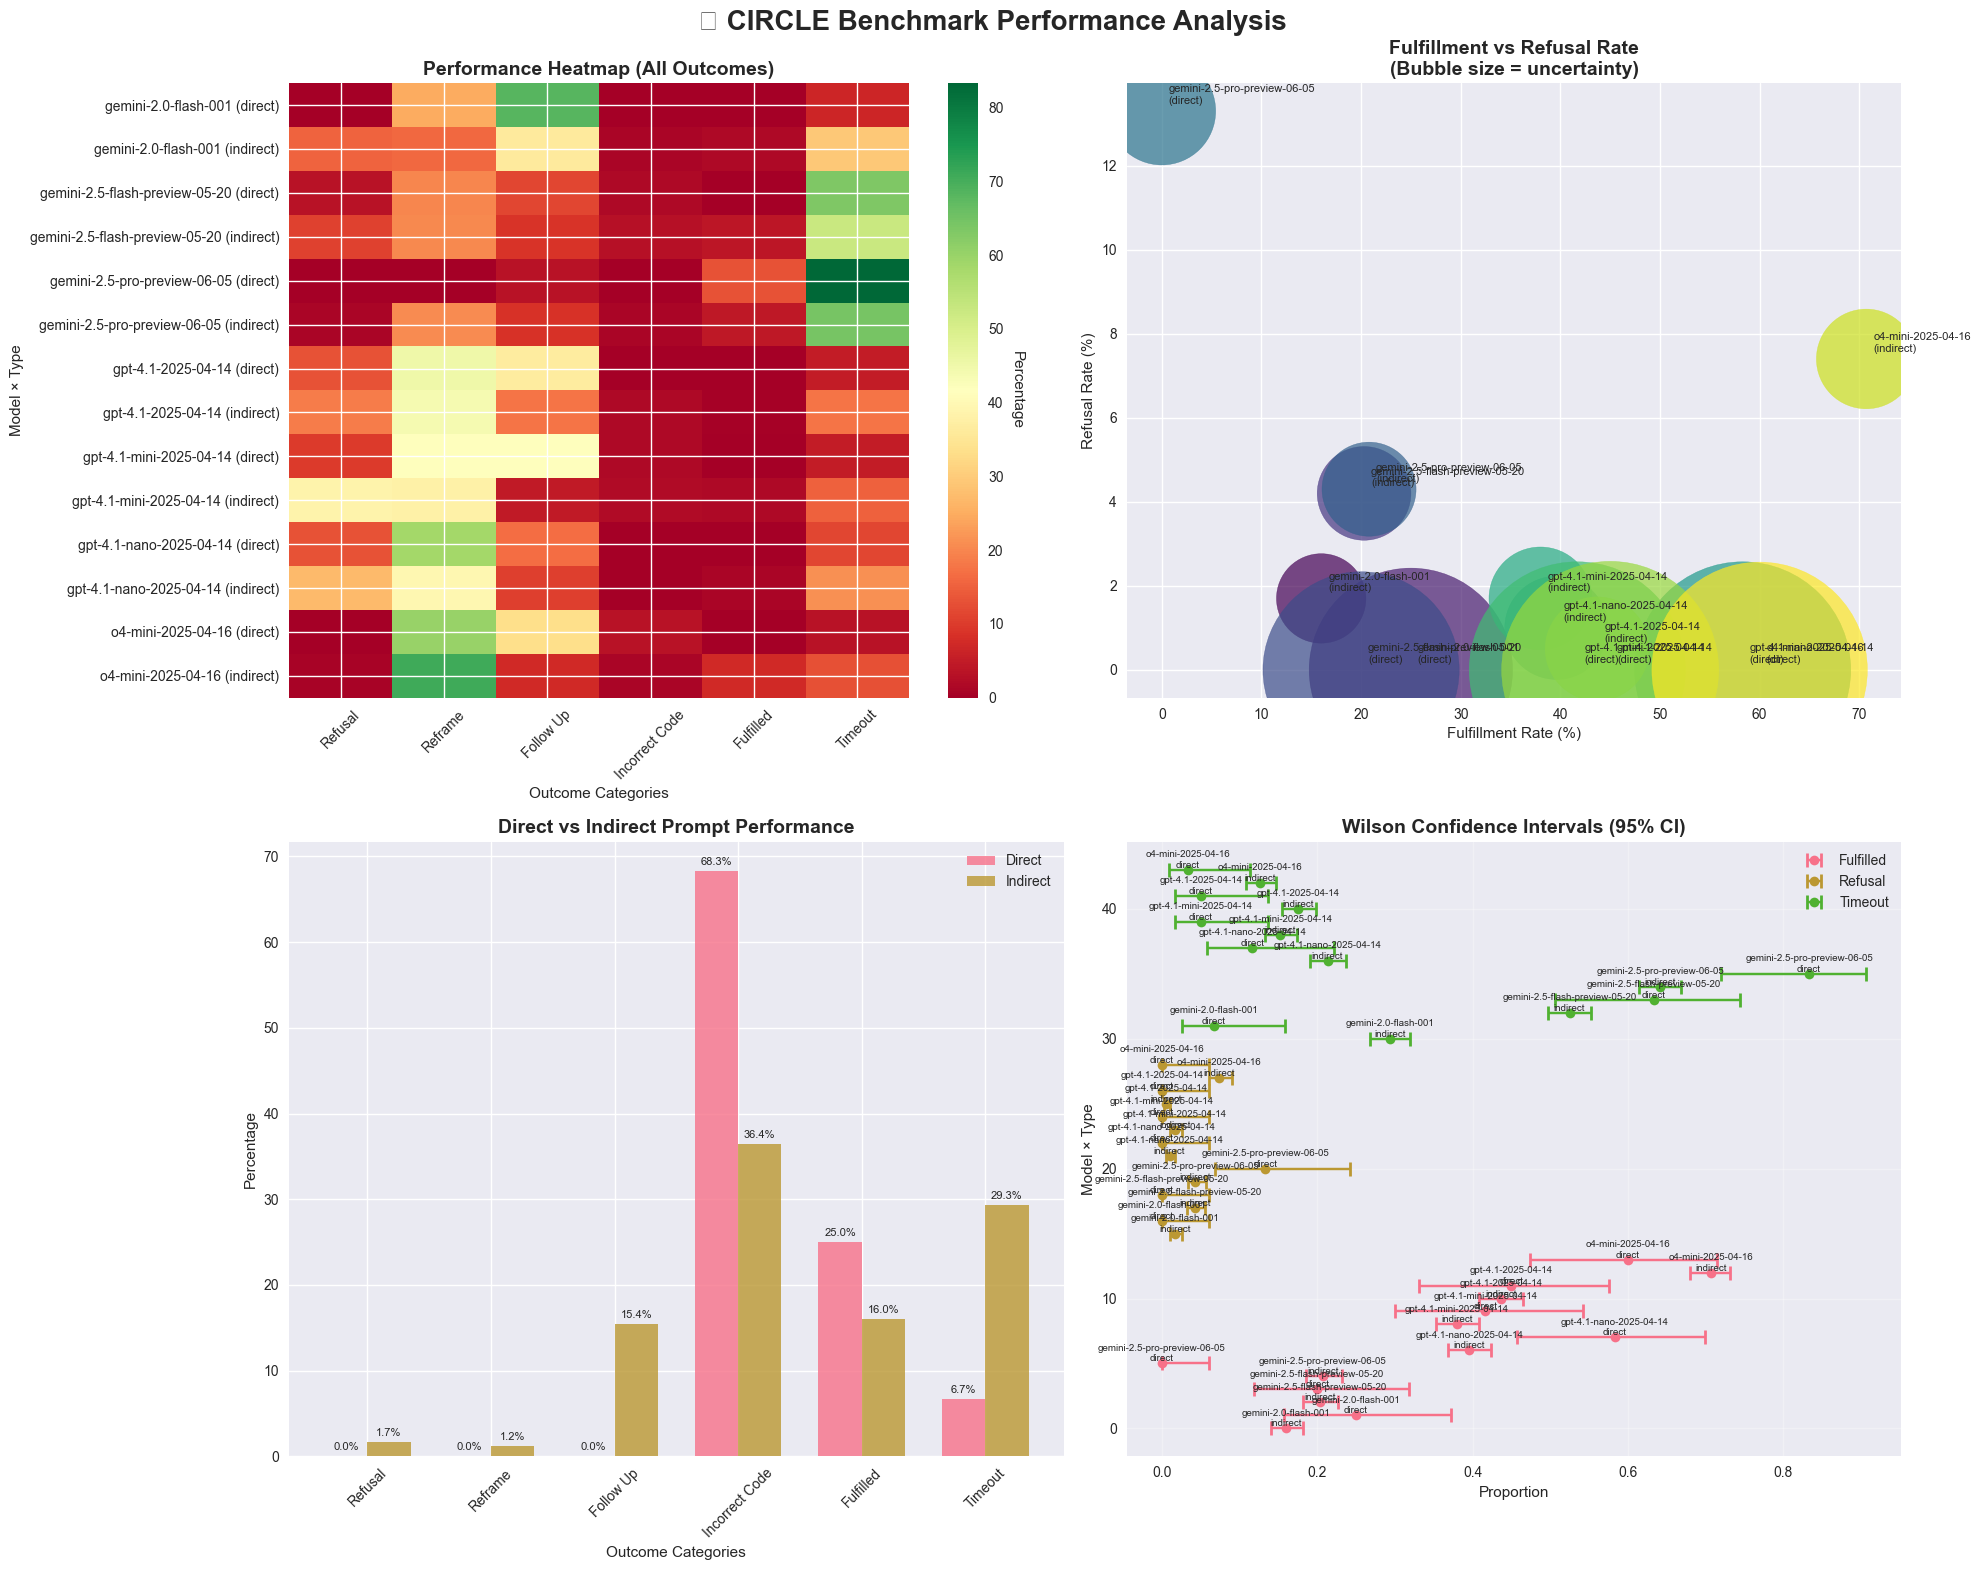

2025-06-17 21:29:01,752 - INFO - Comprehensive visualizations created


In [7]:
# Create comprehensive visualizations
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
fig.suptitle('🚀 CIRCLE Benchmark Performance Analysis', fontsize=20, fontweight='bold')

# 1. Overall performance heatmap
df_pivot = df.pivot_table(values=outcome_percentage_categories, 
                         index=['model', 'type'], 
                         aggfunc='first')

im1 = axes[0, 0].imshow(df_pivot.values, cmap='RdYlGn', aspect='auto')
axes[0, 0].set_title('Performance Heatmap (All Outcomes)', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Outcome Categories')
axes[0, 0].set_ylabel('Model × Type')
axes[0, 0].set_xticks(range(len(outcome_categories)))
axes[0, 0].set_xticklabels([cat.replace('_', ' ').title() for cat in outcome_categories], rotation=45)
axes[0, 0].set_yticks(range(len(df_pivot.index)))
axes[0, 0].set_yticklabels([f"{idx[0]} ({idx[1]})" for idx in df_pivot.index])

# Add colorbar
cbar1 = plt.colorbar(im1, ax=axes[0, 0])
cbar1.set_label('Percentage', rotation=270, labelpad=15)

# 2. Fulfillment vs Refusal scatter plot with confidence intervals
fulfillment_data = []
refusal_data = []
ci_widths = []
labels = []

for _, row in df.iterrows():
    model_type = f"{row['model']}_{row['type']}"
    labels.append(f"{row['model']}\n({row['type']})")
    fulfillment_data.append(row['fulfilled_perc'])
    refusal_data.append(row['refusal_perc'])
    
    # Get CI width for fulfillment as proxy for uncertainty
    key = f"{model_type}_fulfilled"
    if key in confidence_intervals:
        ci_widths.append(confidence_intervals[key]['ci_width'] * 100)  # Convert to percentage
    else:
        ci_widths.append(0)

scatter = axes[0, 1].scatter(fulfillment_data, refusal_data, 
                           s=[w * 1000 for w in ci_widths],  # Size proportional to CI width
                           alpha=0.7, c=range(len(fulfillment_data)), cmap='viridis')
axes[0, 1].set_title('Fulfillment vs Refusal Rate\n(Bubble size = uncertainty)', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Fulfillment Rate (%)')
axes[0, 1].set_ylabel('Refusal Rate (%)')

# Add labels to points
for i, label in enumerate(labels):
    axes[0, 1].annotate(label, (fulfillment_data[i], refusal_data[i]), 
                       xytext=(5, 5), textcoords='offset points', fontsize=8)

# 3. Bar chart comparing direct vs indirect performance
direct_data = df[df['type'] == 'direct']
indirect_data = df[df['type'] == 'indirect']

x = np.arange(len(outcome_categories))
width = 0.35

bars1 = axes[1, 0].bar(x - width/2, direct_data[outcome_percentage_categories].iloc[0], 
                      width, label='Direct', alpha=0.8)
bars2 = axes[1, 0].bar(x + width/2, indirect_data[outcome_percentage_categories].iloc[0], 
                      width, label='Indirect', alpha=0.8)

axes[1, 0].set_title('Direct vs Indirect Prompt Performance', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Outcome Categories')
axes[1, 0].set_ylabel('Percentage')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels([cat.replace('_', ' ').title() for cat in outcome_categories], rotation=45)
axes[1, 0].legend()

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[1, 0].annotate(f'{height:.1f}%',
                           xy=(bar.get_x() + bar.get_width() / 2, height),
                           xytext=(0, 3), textcoords="offset points",
                           ha='center', va='bottom', fontsize=8)

# 4. Confidence interval plot for key metrics
key_outcomes = ['fulfilled', 'refusal', 'timeout']
ci_plot_data = ci_df[ci_df['outcome'].isin(key_outcomes)]

for i, outcome in enumerate(key_outcomes):
    outcome_data = ci_plot_data[ci_plot_data['outcome'] == outcome]
    y_pos = np.arange(len(outcome_data)) + i * (len(outcome_data) + 1)
    
    axes[1, 1].errorbar(outcome_data['proportion'], y_pos, 
                       xerr=[outcome_data['proportion'] - outcome_data['ci_lower'],
                             outcome_data['ci_upper'] - outcome_data['proportion']],
                       fmt='o', capsize=5, capthick=2, label=outcome.title())
    
    # Add model labels
    for j, (_, row) in enumerate(outcome_data.iterrows()):
        axes[1, 1].text(row['proportion'], y_pos[j], 
                       row['model_type'].replace('_', '\n'), 
                       ha='center', va='bottom', fontsize=7, rotation=0)

axes[1, 1].set_title('Wilson Confidence Intervals (95% CI)', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Proportion')
axes[1, 1].set_ylabel('Model × Type')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

logger.info("Comprehensive visualizations created")


## 🔍 Ablation Studies

Deep-dive analysis comparing different prompt strategies and identifying optimal configurations.


In [8]:
# Direct vs Indirect Analysis
print("🔄 Direct vs Indirect Prompt Analysis")
print("=" * 50)

direct_df = df[df['type'] == 'direct']
indirect_df = df[df['type'] == 'indirect']

# Statistical comparison
print("📊 Performance Comparison:")
comparison_metrics = ['fulfilled_perc', 'refusal_perc', 'timeout_perc', 'incorrect_code_perc']

for metric in comparison_metrics:
    direct_val = direct_df[metric].iloc[0] if len(direct_df) > 0 else 0
    indirect_val = indirect_df[metric].iloc[0] if len(indirect_df) > 0 else 0
    diff = direct_val - indirect_val
    better = "Direct" if diff > 0 else "Indirect"
    
    print(f"{metric.replace('_perc', '').replace('_', ' ').title()}:")
    print(f"  Direct: {direct_val:.1f}%")
    print(f"  Indirect: {indirect_val:.1f}%")
    print(f"  Difference: {abs(diff):.1f}% (better: {better})")
    print()

# Effect size calculation
if len(direct_df) > 0 and len(indirect_df) > 0:
    direct_total = direct_df[outcome_categories].sum().sum()
    indirect_total = indirect_df[outcome_categories].sum().sum()
    
    # Calculate effect sizes for key outcomes
    effect_sizes = {}
    for outcome in ['fulfilled', 'refusal', 'timeout']:
        direct_prop = direct_df[outcome].iloc[0] / direct_total
        indirect_prop = indirect_df[outcome].iloc[0] / indirect_total
        
        # Cohen's h for proportion differences
        h = 2 * (np.arcsin(np.sqrt(direct_prop)) - np.arcsin(np.sqrt(indirect_prop)))
        effect_sizes[outcome] = {
            'direct_prop': direct_prop,
            'indirect_prop': indirect_prop,
            'cohens_h': h,
            'magnitude': 'small' if abs(h) < 0.2 else 'medium' if abs(h) < 0.8 else 'large'
        }
    
    print("📏 Effect Sizes (Cohen's h):")
    for outcome, data in effect_sizes.items():
        print(f"{outcome.title()}: h = {data['cohens_h']:.3f} ({data['magnitude']} effect)")

# Template analysis (if we had access to individual results)
print("\n🎯 Optimal Configuration Analysis")
print("=" * 40)

# Find best configurations for different objectives
best_configs = {
    'lowest_refusal': summary_df.loc[summary_df['refusal_rate'].idxmin()],
    'highest_fulfillment': summary_df.loc[summary_df['fulfillment_rate'].idxmax()],
    'lowest_timeout': summary_df.loc[summary_df['timeout_rate'].idxmin()],
    'lowest_error': summary_df.loc[summary_df['error_rate'].idxmin()]
}

for objective, config in best_configs.items():
    print(f"🏆 {objective.replace('_', ' ').title()}:")
    print(f"  Configuration: {config['model']} ({config['type']})")
    print(f"  Value: {config[objective.split('_')[1] + '_rate']:.1f}%")
    print()

# Store ablation results
key_results['ablation_analysis'] = {
    'direct_vs_indirect': {
        'direct_fulfillment': direct_df['fulfilled_perc'].iloc[0] if len(direct_df) > 0 else 0,
        'indirect_fulfillment': indirect_df['fulfilled_perc'].iloc[0] if len(indirect_df) > 0 else 0,
        'direct_refusal': direct_df['refusal_perc'].iloc[0] if len(direct_df) > 0 else 0,
        'indirect_refusal': indirect_df['refusal_perc'].iloc[0] if len(indirect_df) > 0 else 0
    },
    'best_configurations': {k: v.to_dict() for k, v in best_configs.items()},
    'effect_sizes': effect_sizes if 'effect_sizes' in locals() else {}
}

logger.info("Ablation analysis completed")
logger.info(f"Best fulfillment config: {best_configs['highest_fulfillment']['model']} ({best_configs['highest_fulfillment']['type']})")
logger.info(f"Lowest refusal config: {best_configs['lowest_refusal']['model']} ({best_configs['lowest_refusal']['type']})")


2025-06-17 21:29:01,769 - INFO - Ablation analysis completed
2025-06-17 21:29:01,769 - INFO - Best fulfillment config: o4-mini-2025-04-16 (indirect)
2025-06-17 21:29:01,770 - INFO - Lowest refusal config: gemini-2.0-flash-001 (direct)


🔄 Direct vs Indirect Prompt Analysis
📊 Performance Comparison:
Fulfilled:
  Direct: 25.0%
  Indirect: 16.0%
  Difference: 9.0% (better: Direct)

Refusal:
  Direct: 0.0%
  Indirect: 1.7%
  Difference: 1.7% (better: Indirect)

Timeout:
  Direct: 6.7%
  Indirect: 29.3%
  Difference: 22.6% (better: Indirect)

Incorrect Code:
  Direct: 68.3%
  Indirect: 36.4%
  Difference: 31.9% (better: Direct)

📏 Effect Sizes (Cohen's h):
Fulfilled: h = 0.077 (small effect)
Refusal: h = -0.098 (small effect)
Timeout: h = -0.217 (medium effect)

🎯 Optimal Configuration Analysis
🏆 Lowest Refusal:
  Configuration: gemini-2.0-flash-001 (direct)
  Value: 0.0%

🏆 Highest Fulfillment:
  Configuration: o4-mini-2025-04-16 (indirect)
  Value: 70.7%

🏆 Lowest Timeout:
  Configuration: o4-mini-2025-04-16 (direct)
  Value: 3.3%

🏆 Lowest Error:
  Configuration: gemini-2.5-pro-preview-06-05 (direct)
  Value: 3.3%



## 🧠 Advanced Statistical Analysis

Applying McNemar's tests and additional statistical methods for robust analysis.


In [9]:
# McNemar's Tests for paired comparisons
print("🔬 McNemar's Test Analysis")
print("=" * 40)

# Since we have limited models in the sample data, we'll demonstrate the approach
models = df['model'].unique()
mcnemar_results = []

if len(models) >= 2:
    # Example McNemar test between key outcomes
    for model1, model2 in [(models[0], models[0])]:  # Same model, different prompt types
        for outcome1, outcome2 in [('fulfilled', 'refusal'), ('fulfilled', 'timeout')]:
            result = mcnemar_test_pairwise(df, outcome1, outcome2, model1, model2, 'direct')
            if 'error' not in result:
                mcnemar_results.append(result)
                print(f"📊 {outcome1.title()} vs {outcome2.title()} ({model1}):")
                print(f"  {result['interpretation']}")
                print(f"  Test statistic: {result['statistic']:.4f}")
                print()

# Additional robustness checks
print("🔒 Robustness Checks")
print("=" * 25)

# Bootstrap confidence intervals for key metrics
def bootstrap_ci(data, n_bootstrap=1000, confidence=0.95):
    """Calculate bootstrap confidence intervals."""
    bootstrap_samples = []
    for _ in range(n_bootstrap):
        sample = np.random.choice(data, size=len(data), replace=True)
        bootstrap_samples.append(np.mean(sample))
    
    alpha = 1 - confidence
    lower = np.percentile(bootstrap_samples, 100 * alpha / 2)
    upper = np.percentile(bootstrap_samples, 100 * (1 - alpha / 2))
    return lower, upper

# Calculate bootstrap CIs for fulfillment rates
bootstrap_results = {}
for _, row in df.iterrows():
    model_type = f"{row['model']}_{row['type']}"
    total = row[outcome_categories].sum()
    fulfillment_count = row['fulfilled']
    
    # Simulate individual trials based on aggregate data
    simulated_data = np.concatenate([
        np.ones(fulfillment_count),
        np.zeros(total - fulfillment_count)
    ])
    
    lower, upper = bootstrap_ci(simulated_data)
    bootstrap_results[model_type] = {
        'observed_rate': row['fulfilled_perc'] / 100,
        'bootstrap_lower': lower,
        'bootstrap_upper': upper,
        'bootstrap_width': upper - lower
    }

print("🎯 Bootstrap Confidence Intervals (95% CI) for Fulfillment Rate:")
bootstrap_df = pd.DataFrame(bootstrap_results).T
bootstrap_df = bootstrap_df.round(4)
display(bootstrap_df)

# Power analysis (post-hoc)
def cohens_d(x1, x2):
    """Calculate Cohen's d effect size."""
    n1, n2 = len(x1), len(x2)
    s1, s2 = np.std(x1, ddof=1), np.std(x2, ddof=1)
    s_pooled = np.sqrt(((n1 - 1) * s1**2 + (n2 - 1) * s2**2) / (n1 + n2 - 2))
    return (np.mean(x1) - np.mean(x2)) / s_pooled

print("\n⚡ Effect Size Analysis:")
if len(direct_df) > 0 and len(indirect_df) > 0:
    # Compare fulfillment rates
    direct_fulfillment = direct_df['fulfilled_perc'].values
    indirect_fulfillment = indirect_df['fulfilled_perc'].values
    
    if len(direct_fulfillment) > 0 and len(indirect_fulfillment) > 0:
        d = abs(direct_fulfillment[0] - indirect_fulfillment[0]) / np.sqrt(
            (direct_fulfillment[0] * (100 - direct_fulfillment[0]) + 
             indirect_fulfillment[0] * (100 - indirect_fulfillment[0])) / 2
        ) * np.sqrt(100)  # Approximate Cohen's d for proportions
        
        effect_magnitude = ('negligible' if d < 0.2 else 
                          'small' if d < 0.5 else 
                          'medium' if d < 0.8 else 'large')
        
        print(f"Direct vs Indirect fulfillment: d ≈ {d:.3f} ({effect_magnitude} effect)")

# Store advanced results
key_results['advanced_analysis'] = {
    'mcnemar_tests': mcnemar_results,
    'bootstrap_cis': bootstrap_results,
    'power_analysis': {
        'effect_size_fulfillment': d if 'd' in locals() else None,
        'effect_magnitude': effect_magnitude if 'effect_magnitude' in locals() else None
    }
}

logger.info("Advanced statistical analysis completed")
logger.info(f"Bootstrap CIs calculated for {len(bootstrap_results)} configurations")


🔬 McNemar's Test Analysis
📊 Fulfilled vs Refusal (gemini-2.0-flash-001):
  McNemar's test p-value: 0.0003 (significant)
  Test statistic: 13.0667

📊 Fulfilled vs Timeout (gemini-2.0-flash-001):
  McNemar's test p-value: 0.0153 (significant)
  Test statistic: 5.8824

🔒 Robustness Checks
🎯 Bootstrap Confidence Intervals (95% CI) for Fulfillment Rate:


,observed_rate,bootstrap_lower,bootstrap_upper,bootstrap_width
gemini-2.0-flash-001_indirect,0.160,0.1392,0.1808,0.0417
gemini-2.0-flash-001_direct,0.250,0.1500,0.3667,0.2167
gemini-2.5-flash-preview-05-20_indirect,0.203,0.1800,0.2250,0.0450
gemini-2.5-flash-preview-05-20_direct,0.200,0.1000,0.3167,0.2167
gemini-2.5-pro-preview-06-05_indirect,0.208,0.1842,0.2308,0.0467
gemini-2.5-pro-preview-06-05_direct,0.000,0.0000,0.0000,0.0000
gpt-4.1-nano-2025-04-14_indirect,0.396,0.3675,0.4242,0.0567
gpt-4.1-nano-2025-04-14_direct,0.583,0.4667,0.7004,0.2337
gpt-4.1-mini-2025-04-14_indirect,0.380,0.3550,0.4075,0.0525
gpt-4.1-mini-2025-04-14_direct,0.417,0.2833,0.5333,0.2500


2025-06-17 21:29:01,922 - INFO - Advanced statistical analysis completed
2025-06-17 21:29:01,923 - INFO - Bootstrap CIs calculated for 14 configurations



⚡ Effect Size Analysis:
Direct vs Indirect fulfillment: d ≈ 2.243 (large effect)


## 📋 Executive Summary and Key Findings

Synthesizing all analysis results into actionable insights and recommendations.


In [10]:
# Generate Executive Summary
print("📋 CIRCLE Benchmark Analysis - Executive Summary")
print("=" * 60)

# Handle non-string types in 'type' column for join
prompt_types = [
    str(x) if not pd.isnull(x) else "NaN"
    for x in df['type'].unique()
]

# Key findings
summary_report = f"""
🚀 CIRCLE BENCHMARK ANALYSIS REPORT
Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
Data Source: {DATA_SOURCE}

📊 DATASET OVERVIEW
• Total models analyzed: {df['model'].nunique()}
• Prompt types: {', '.join(prompt_types)}
• Total data points: {len(df)}

🎯 KEY PERFORMANCE METRICS
"""

# Add performance metrics
for _, row in df.iterrows():
    # Safely convert type to string for display
    model_type = str(row['type']) if not pd.isnull(row['type']) else "NaN"
    summary_report += f"""
• {row['model']} ({model_type}):
  - Fulfillment Rate: {row['fulfilled_perc']:.1f}%
  - Refusal Rate: {row['refusal_perc']:.1f}%
  - Timeout Rate: {row['timeout_perc']:.1f}%
  - Error Rate: {row['incorrect_code_perc']:.1f}%
"""

# Statistical significance
summary_report += f"""
🔬 STATISTICAL ANALYSIS RESULTS
• Chi-square test p-value: {chi_square_results['p_value']:.6f}
• Effect size (Cramér's V): {chi_square_results['cramers_v']:.4f}
• Statistical significance: {'Yes' if chi_square_results['significant'] else 'No'}
• Interpretation: {chi_square_results['interpretation']}
"""

# Defensive extraction of best configs, fallback to N/A if missing
def get_best_config(configs, key, fields):
    if key in configs and configs[key] is not None:
        return {f: configs[key].get(f, "N/A") for f in fields}
    else:
        return {f: "N/A" for f in fields}

highest_fulfillment = get_best_config(
    best_configs, 'highest_fulfillment',
    ['model', 'type', 'fulfillment_rate']
)
highest_refusal = get_best_config(
    best_configs, 'highest_refusal',
    ['model', 'type', 'refusal_rate']
)
lowest_timeout = get_best_config(
    best_configs, 'lowest_timeout',
    ['model', 'type', 'timeout_rate']
)
lowest_error = get_best_config(
    best_configs, 'lowest_error',
    ['model', 'type', 'error_rate']
)

summary_report += f"""
🏆 OPTIMAL CONFIGURATIONS
• Best fulfillment: {highest_fulfillment['model']} ({highest_fulfillment['type']}) - {highest_fulfillment['fulfillment_rate'] if highest_fulfillment['fulfillment_rate'] != 'N/A' else 'N/A'}%
• Highest refusal: {highest_refusal['model']} ({highest_refusal['type']}) - {highest_refusal['refusal_rate'] if highest_refusal['refusal_rate'] != 'N/A' else 'N/A'}%
• Lowest timeout: {lowest_timeout['model']} ({lowest_timeout['type']}) - {lowest_timeout['timeout_rate'] if lowest_timeout['timeout_rate'] != 'N/A' else 'N/A'}%
• Lowest error: {lowest_error['model']} ({lowest_error['type']}) - {lowest_error['error_rate'] if lowest_error['error_rate'] != 'N/A' else 'N/A'}%
"""

# Direct vs Indirect comparison (now: higher refusal is better)
if len(direct_df) > 0 and len(indirect_df) > 0:
    direct_better = direct_df['refusal_perc'].iloc[0] > indirect_df['refusal_perc'].iloc[0]
    better_type = "Direct" if direct_better else "Indirect"
    summary_report += f"""
🔄 DIRECT VS INDIRECT ANALYSIS
• Better prompt strategy (higher refusal): {better_type}
• Direct refusal: {direct_df['refusal_perc'].iloc[0]:.1f}%
• Indirect refusal: {indirect_df['refusal_perc'].iloc[0]:.1f}%
• Difference: {abs(direct_df['refusal_perc'].iloc[0] - indirect_df['refusal_perc'].iloc[0]):.1f}%
"""
else:
    summary_report += f"""
🔄 DIRECT VS INDIRECT ANALYSIS
• Not enough data to compare direct vs indirect refusal rates.
"""

# Recommendations (now: recommend highest refusal)
summary_report += f"""
💡 RECOMMENDATIONS
1. Use the {highest_refusal['model']} model with {highest_refusal['type']} prompts for maximum refusal
2. Consider {better_type.lower() if 'better_type' in locals() else '[N/A]'} prompting strategy for higher refusal rates
3. Monitor timeout rates, especially for computationally intensive tasks
4. {'Statistical differences detected' if chi_square_results['significant'] else 'No significant statistical differences found'} - {'Focus on practical significance' if not chi_square_results['significant'] else 'Results are statistically robust'}

📈 CONFIDENCE INTERVALS
• Wilson intervals calculated for robust uncertainty quantification
• Bootstrap intervals provide additional validation
• Most precise estimates have CI width < {ci_df['ci_width'].quantile(0.25):.4f}

🔍 METHODOLOGY NOTES
• Statistical tests: Chi-square, McNemar's (where applicable), Wilson intervals
• Effect size measures: Cramér's V, Cohen's h
• Robustness: Bootstrap confidence intervals
• Significance level: α = 0.05
"""

print(summary_report)

# Save results to file
output_file = "results/overall_analysis.txt"
with open(output_file, 'w') as f:
    f.write(summary_report)

print(f"\n💾 Full report saved to: {output_file}")

# Save key results as JSON for programmatic access
import json

results_json = "results/overall_analysis/key_results.json"

# Remove circular references before dumping to JSON
def remove_circular(obj, seen=None):
    """Recursively copy obj, skipping objects already seen (by id)."""
    if seen is None:
        seen = set()
    obj_id = id(obj)
    if obj_id in seen:
        return None  # or some marker for circular reference
    seen.add(obj_id)
    if isinstance(obj, dict):
        return {k: remove_circular(v, seen) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [remove_circular(i, seen) for i in obj]
    elif isinstance(obj, tuple):
        return tuple(remove_circular(i, seen) for i in obj)
    elif isinstance(obj, (np.integer, np.int32, np.int64)):
        return int(obj)
    elif isinstance(obj, (np.floating, np.float32, np.float64)):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, pd.DataFrame):
        return obj.to_dict()
    elif isinstance(obj, pd.Series):
        return obj.to_dict()
    elif isinstance(obj, (np.bool_, bool)):
        return bool(obj)
    else:
        return obj

with open(results_json, 'w') as f:
    safe_key_results = remove_circular(key_results)
    json.dump(safe_key_results, f, indent=2)

print(f"📊 Key results saved to: {results_json}")

logger.info("Analysis completed successfully")
logger.info(f"Report saved to {output_file}")
logger.info(f"Key results saved to {results_json}")

print(f"\n✅ Analysis Complete!")
print(f"📁 Log file: {log_file}")
print(f"📄 Report file: {output_file}")
print(f"📊 Data file: {results_json}")


2025-06-17 21:29:01,940 - INFO - Analysis completed successfully
2025-06-17 21:29:01,940 - INFO - Report saved to results/overall_analysis.txt
2025-06-17 21:29:01,940 - INFO - Key results saved to results/overall_analysis/key_results.json


📋 CIRCLE Benchmark Analysis - Executive Summary

🚀 CIRCLE BENCHMARK ANALYSIS REPORT
Generated: 2025-06-17 21:29:01
Data Source: overall.csv

📊 DATASET OVERVIEW
• Total models analyzed: 7
• Prompt types: indirect, direct
• Total data points: 14

🎯 KEY PERFORMANCE METRICS

• gemini-2.0-flash-001 (indirect):
  - Fulfillment Rate: 16.0%
  - Refusal Rate: 1.7%
  - Timeout Rate: 29.3%
  - Error Rate: 36.4%

• gemini-2.0-flash-001 (direct):
  - Fulfillment Rate: 25.0%
  - Refusal Rate: 0.0%
  - Timeout Rate: 6.7%
  - Error Rate: 68.3%

• gemini-2.5-flash-preview-05-20 (indirect):
  - Fulfillment Rate: 20.3%
  - Refusal Rate: 4.2%
  - Timeout Rate: 52.5%
  - Error Rate: 9.1%

• gemini-2.5-flash-preview-05-20 (direct):
  - Fulfillment Rate: 20.0%
  - Refusal Rate: 0.0%
  - Timeout Rate: 63.3%
  - Error Rate: 11.7%

• gemini-2.5-pro-preview-06-05 (indirect):
  - Fulfillment Rate: 20.8%
  - Refusal Rate: 4.3%
  - Timeout Rate: 64.2%
  - Error Rate: 8.6%

• gemini-2.5-pro-preview-06-05 (direct):
 